In [1]:
# Import required packages
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
import timeit
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical


## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
%%time
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

CPU times: total: 6.45 s
Wall time: 6.49 s


In [3]:
predicted_clean_labels = np.genfromtxt('../output/predicted_clean_label.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer
CPU times: total: 62.5 ms
Wall time: 56 ms


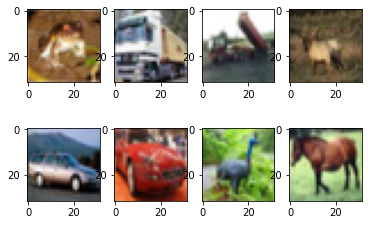

In [4]:
%%time
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [5]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [6]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [7]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2 Model I

In [8]:
# Splitting data into training and testing sets

x_train, x_test, y_train, y_test = train_test_split(imgs, noisy_labels, test_size = 0.2, random_state=42)

#validation set

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

#normalizing x
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_valid = np.array(x_valid) / 255

####  You can skip or stop this chunk of training model

In [9]:
# #skip this chunk if no need to train the model

# #create model
# model = Sequential()
    
# #add model layers
# model.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(32, 32, 3)))
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
# model.add(Flatten())
# model.add(Dense(64, activation="relu"))
# model.add(Dense(10, activation="softmax"))

# #compile model
# #accuracy to measure model performance
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# #train the model
# history = model.fit(
#     x_train, 
#     to_categorical(y_train), 
#     epochs=6, 
#     validation_data=(x_valid, to_categorical(y_valid)))

# # Epoch = 6 gives optimal model, Epoch > 6 tends to be overfitting
# basecnn = model

# #save model
# basecnn.save("../output/basecnn.h5")

#### resume here: load the trained model and make prediction

In [10]:
# CNN
basecnn = keras.models.load_model('../output/basecnn.h5')
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    #predict
    #x_test = np.array(image)/255
    predictions = basecnn.predict(image)
    np.argmax(predictions, axis=1)
    return np.argmax(predictions, axis=1)

In [11]:
# test
start = timeit.default_timer()
history = model_I(x_test)
stop = timeit.default_timer()
total_time = (stop - start) / 60
print('Model I took', total_time,'minutes to predict the labels for x_test')

Model I took 0.030928161666666714 minutes to predict the labels for x_test


In [12]:
basecnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 4096)              0

In [13]:
#model_I(imgs[49999])
#np.argmax(basecnn.predict(np.array(imgs[49999:])/255))
#predictions = basecnn.predict(x_test[:25])
print("First 25 labels from the model prediction:", model_I(x_test[:25]))
print("First 25 labels from the testing set:     ", y_test[:25])

First 25 labels from the model prediction: [5 8 8 4 1 7 8 9 6 1 8 3 8 7 1 5 6 6 4 5 8 5 6 2 4]
First 25 labels from the testing set:      [0 8 1 6 1 2 2 7 6 3 5 5 0 8 1 6 9 5 4 7 0 5 7 0 9]


### 2.3. Model II: cnn with predicted clean labels

In [14]:
# load the predicted clean labels
predicted_clean_labels = np.genfromtxt('../output/predicted_clean_label.csv', delimiter=',', dtype="int8")

# Splitting data into training and testing sets

x_train, x_test, y_train, y_test = train_test_split(imgs, predicted_clean_labels, test_size = 0.2, random_state=42)

#validation set

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

#normalizing x
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_valid = np.array(x_valid) / 255

#### You can skip or stop this chunk of training model

In [15]:
# #skip this chunk if no need to train the model

# #create model
# model = Sequential()
    
# #add model layers
# model.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(32, 32, 3)))
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
# model.add(Flatten())
# model.add(Dense(64, activation="relu"))
# model.add(Dense(10, activation="softmax"))

# #compile model
# #accuracy to measure model performance
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# #train the model
# history = model.fit(
#     x_train, 
#     to_categorical(y_train), 
#     epochs=8, 
#     validation_data=(x_valid, to_categorical(y_valid)))

# # Epoch = 8 gives optimal model, Epoch > 8 tends to be overfitting
# advancecnn = model

# #save model
# advancecnn.save("../output/advancecnn.h5")

#### resume here: load the trained model and make prediction

In [16]:
# CNN with predicted clean label trained by semi-supervised learning(Flexmatch)
advancecnn = keras.models.load_model('../output/advancecnn.h5')
def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    #predict
    #x_test = np.array(image)/255
    predictions = advancecnn.predict(image)
    np.argmax(predictions, axis=1)
    return np.argmax(predictions, axis=1)

In [17]:
# test
start = timeit.default_timer()
history = model_II(x_test)
stop = timeit.default_timer()
total_time = (stop - start) / 60
print('Model II took', total_time,'minutes to predict the labels for x_test')

Model II took 0.0309564633333333 minutes to predict the labels for x_test


In [18]:
advancecnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 4096)             

In [19]:
print("First 25 labels from the model prediction:", model_II(x_test[:25]))
print("First 25 labels from the testing set:     ", y_test[:25])

First 25 labels from the model prediction: [3 8 0 6 1 6 8 8 3 3 0 5 0 7 1 6 9 6 3 5 0 7 7 2 4]
First 25 labels from the testing set:      [7 8 0 6 1 6 8 0 6 5 2 7 0 7 1 6 5 6 6 5 0 5 7 2 4]


## Predictions

In [20]:
# load the images
test_n_img = 10000
test_imgs = np.empty((test_n_img,32,32,3))
for i in range(len(test_imgs)):
    test_img_fn = f'../data/images/{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(test_img_fn),cv2.COLOR_BGR2RGB)


In [21]:
# index 
index_list = []
for  i in range(len(test_imgs)):
    test_index = f'test{i+1:05d}'
    index_list.append(test_index)

# Baseline
text_images = imgs[0:10000]
baseline_preds_list = []
for  i in range(len(test_imgs)):
    baseline_prediction = int(baseline_model(test_imgs[i]))
    baseline_preds_list.append(baseline_prediction)
    
# MODEL_I
model_I_preds = model_I(test_imgs)

# MODEL_II
model_II_preds = model_II(test_imgs)

dict = {'index':index_list, 'Baseline':baseline_preds_list,
        'Model I':model_I_preds, 'Model II':model_II_preds}
predictions_II_df = pd.DataFrame(dict)
predictions_II_df.to_csv('../output/label_prediction.csv', index=False)

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [22]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [23]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

OSError: ../data/test_labels.csv not found.

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

In [ ]:
%whos
#labels = target_vec[25000:]
#evaluation(baseline_model, labels, imgs[25000:])
#imgs[:2]